In [1]:
import gym
import numpy as np

from tqdm import trange

env = gym.make('Pendulum-v0')

The pendulum challenge is to keep a 
frictionless pendulum standing up

# The Pendulum

## States

| Num | Observation |
|:-:|:-:|
| 0 | cos(theta) |
| 1 | sin(theta) |
| 2 | theta dot |


<style>
td {
  font-size: 100px
}
    
    
</style>


In [2]:
print(f"The shape of the state space: {env.observation_space.shape}")
print(f"Highest value: {env.observation_space.high}")
print(f"Lowest value: {env.observation_space.low}")

env.observation_space

print(f"A sample state: {env.observation_space.sample()}")

The shape of the state space: (3,)
Highest value: [1. 1. 8.]
Lowest value: [-1. -1. -8.]
A sample state: [-0.885673    0.14482147  2.3693333 ]


## Actions

| Num | Action |
|:-:|:-:|
| 0 | Joint effort |

In [3]:
print(f"The shape of the action space: {env.action_space.shape}")
print(f"Highest value: {env.action_space.high}")
print(f"Lowest value: {env.action_space.low}")

env.action_space.seed(473)

print(f"A sample action: {env.action_space.sample()}")

The shape of the action space: (1,)
Highest value: [2.]
Lowest value: [-2.]
A sample action: [-0.8608973]


In [4]:
env.action_space.sample()

array([1.8785995], dtype=float32)

## Reward

Function: $-(theta^2 + 0.1*thetaDot^2 + 0.001*action^2)$

# The Agent

In [5]:
import sys
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class Agent:
    def __init__(self):
        pass
    
    def act(self, state):
        return [np.random.normal(0., .8)]


In [7]:
## Utils
   
class ScoreEvaluator:
    def __init__(self, window: int):
        self.window = window
        self.best_score = -np.inf
        self.avg_scores = []
        self.tmp_scores = deque(maxlen=window)
        self.last_score = None
        
    def add(self, score: float):
        if not score:
            raise ValueError(f'Score could not be {score}')
         
        self.tmp_scores.append(score)
        
        if score > self.best_score:
            self.best_score = score
        
        self._update_avg()
        self.last_score = score
        
    def plot_avg_scores(self):
        plt.plot(np.linspace(0,
                             len(self.avg_scores),
                             len(self.avg_scores),
                             endpoint=False),
                 np.asarray(self.avg_scores))
        plt.title(f'Best Reward: {self.best_score:10.5f}')
        plt.xlabel('Episode Number')
        plt.ylabel(f'Average Actions made (Over Next {self.window} Episodes)')
        plt.show()
        
    def _update_avg(self):
        if len(self.tmp_scores) < self.tmp_scores.maxlen:
            return
        self.avg_scores.append(np.mean(self.tmp_scores))
        
def print_iteaction(iteraction: int, score_eval: ScoreEvaluator):
    "function responsible to print some infos each iteration"
    print("{:4d} - Best Score: {:5.2f} - {:5.2f}".format(iteraction,
                                                         score_eval.best_score,
                                                         score_eval.last_score),
          end="\r",
          flush=True)

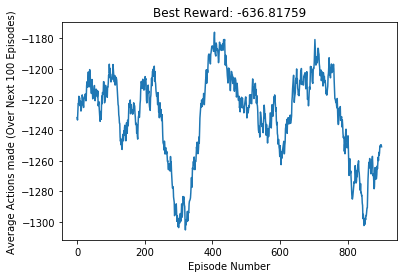

In [8]:
num_episodes = 1000

agent = Agent()

best_score = -np.inf

avg_scores = deque(maxlen=num_episodes)

score_eval = ScoreEvaluator(100)

for i in range(num_episodes):  
    score = 0
    state = env.reset()
    
    for _ in range(300):
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        
        score += reward
        if done:
            score_eval.add(score)
            print_iteaction(i, score_eval)
            break
            
score_eval.plot_avg_scores()